In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import pathlib
Dataset_Path = 'data_path/'
data_dir = pathlib.Path(Dataset_Path)

In [3]:
import os
import numpy as np
import glob
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

def GetFileName(root,root_len):
    filenames = glob.glob(os.path.join(root, '*_image1.png'))
    #check if is nan
    label = pd.read_csv(root+ "/train.csv")
    label = label.dropna()
    label = label['id']
    label = label.array
    #delete nan hand
    count = len(filenames) - 1
    while (count >= 0):
        if (filenames[count][-(len(filenames[count]))+root_len+1:-11] not in label):
            filenames.remove(filenames[count])
        count = count - 1
    return filenames

def replication (paths,root_len):
    label = pd.read_csv('data_path/train.csv',index_col='id')
    orilen = len(paths)
    for i in range(orilen):
        if label.loc[paths[i][-(len(paths[i]))+root_len+1:-11]][0] == 1:
            paths.append(paths[i])
    return paths

class GetDataSet(Dataset):
    def __init__(self,file,file_paths,train=True):
        self.file_paths = file_paths #file names of images
        self.train = train
        self.resize = transforms.Resize((224,224))
        if (self.train):
            self.transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(180, expand=True),
                transforms.Resize((224,224)),
                transforms.RandomEqualize(1),
                transforms.ToTensor()
                ])
        else:
            self.transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomEqualize(1),
                transforms.ToTensor()
                ])
        self.num_samples = len(self.file_paths)
        self.filenames = glob.glob(os.path.join(os.path.join('data_path/',file), "*.png"))
        self.label = pd.read_csv('data_path/train.csv',index_col='id')
        self.train_folder = 'data_path/train'

    def __getitem__(self,idx):
        file_path = self.file_paths[idx]
        img1 = torchvision.io.read_image(file_path,torchvision.io.ImageReadMode(1))
        img1 = self.transforms(img1)
        img1 = self.padding(img1)
        check = 0
        if(file_path[-len(file_path):-5]+'2.png' in self.filenames):
            img2 = torchvision.io.read_image(file_path[-len(file_path):-5]+'2.png',torchvision.io.ImageReadMode(1))
            img2 = self.transforms(img2)
            img2 = self.padding(img2)
            check = check + 1
        if(file_path[-len(file_path):-5]+'3.png' in self.filenames):
            img3 = torchvision.io.read_image(file_path[-len(file_path):-5]+'3.png',torchvision.io.ImageReadMode(1))
            img3 = self.transforms(img3)
            img3 = self.padding(img3)
            check = check + 1
        if(file_path[-len(file_path):-5]+'4.png' in self.filenames):
            img4 = torchvision.io.read_image(file_path[-len(file_path):-5]+'4.png',torchvision.io.ImageReadMode(1))
            img4 = self.transforms(img4)
            img4 = self.padding(img4)
            check = check + 1
        if (check == 3):img = torch.cat((img1,img2,img3,img4))
        elif (check == 2):img = torch.cat((img1,img2,img3,img1))
        elif (check == 1):img = torch.cat((img1,img2,img1,img1))
        else:img = torch.cat((img1,img1,img1,img1))
        
        if (self.train):
            return img,self.label.loc[file_path[-len(file_path)+len(self.train_folder)+1:-11]][0]
        else:
            return img
        
    def __len__(self):
        return self.num_samples

    def padding(self,img):
        h = img.size()[0]
        w = img.size()[1]
        if w != 224 or h != 224:
            if h > w:
                img = F.pad(img,((h-w)/2),((h-w)/2),0,0)
            elif w < h:
                img = F.pad(img,(0,0,(w-h)/2),((w-h)/2),0,0)
            img = self.resize(img)
        return img



/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_folder = 'data_path/train'
train_paths = GetFileName('data_path/train',len(train_folder))
train_paths = replication(train_paths,len(train_folder))
test_paths = glob.glob(os.path.join('data_path/test', '*_image1.png'))
train_dataset = GetDataSet('train',train_paths,train = True)
test_dataset = GetDataSet('test',test_paths,train = False)

In [5]:
print(len(train_dataset))
print(len(test_dataset))

3525
500


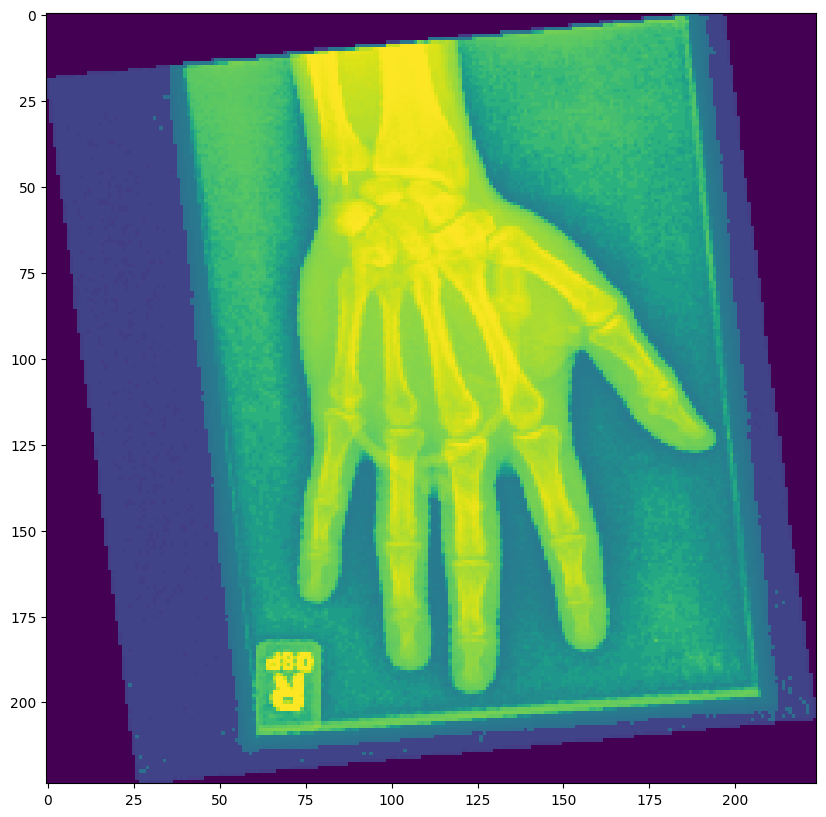

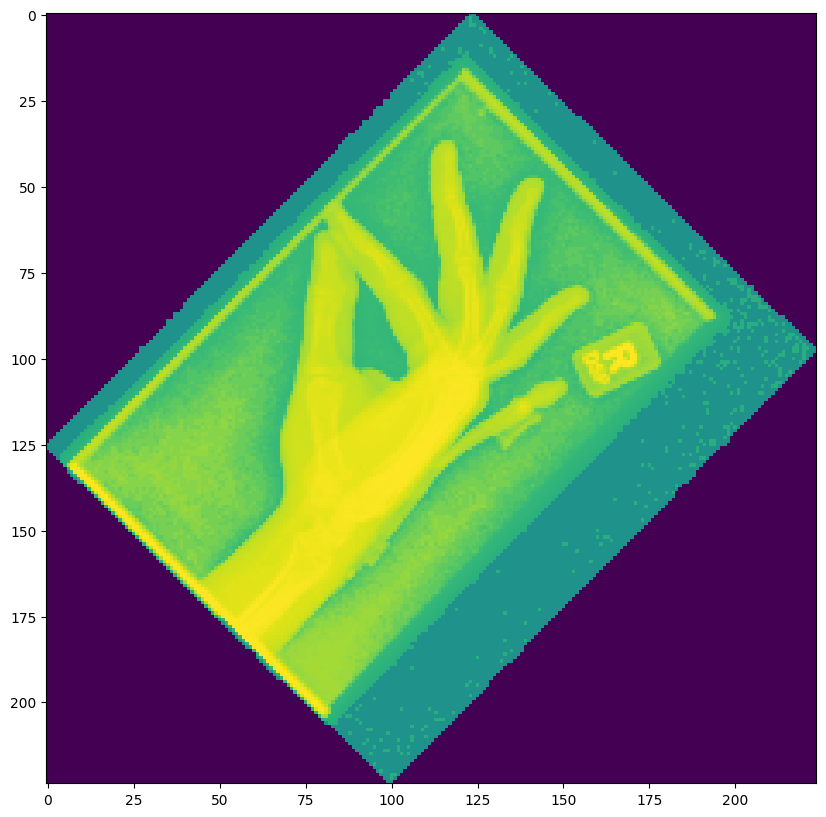

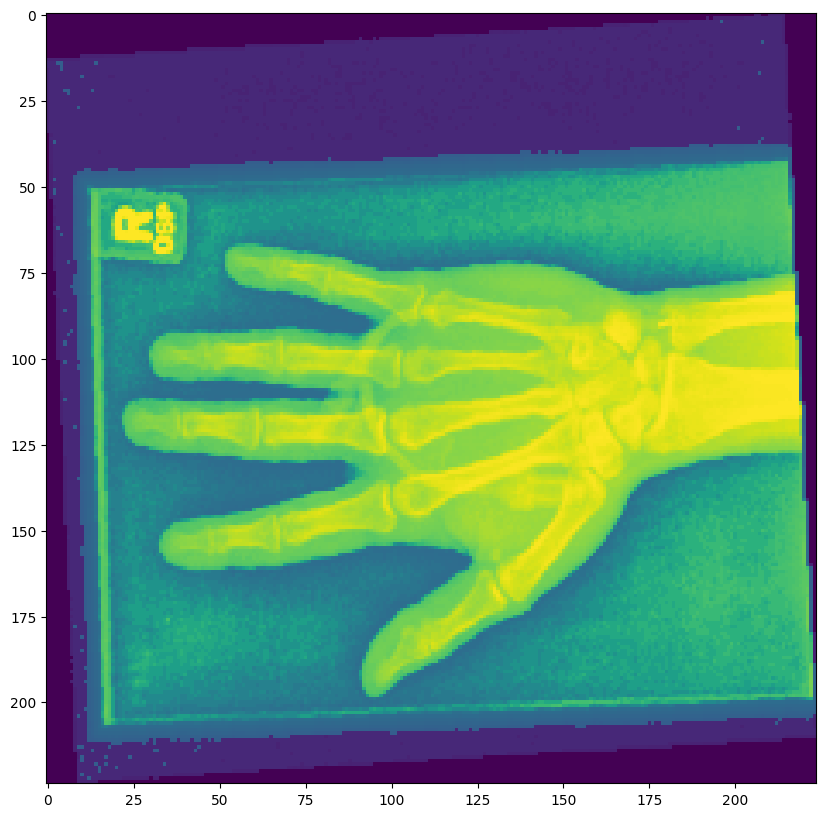

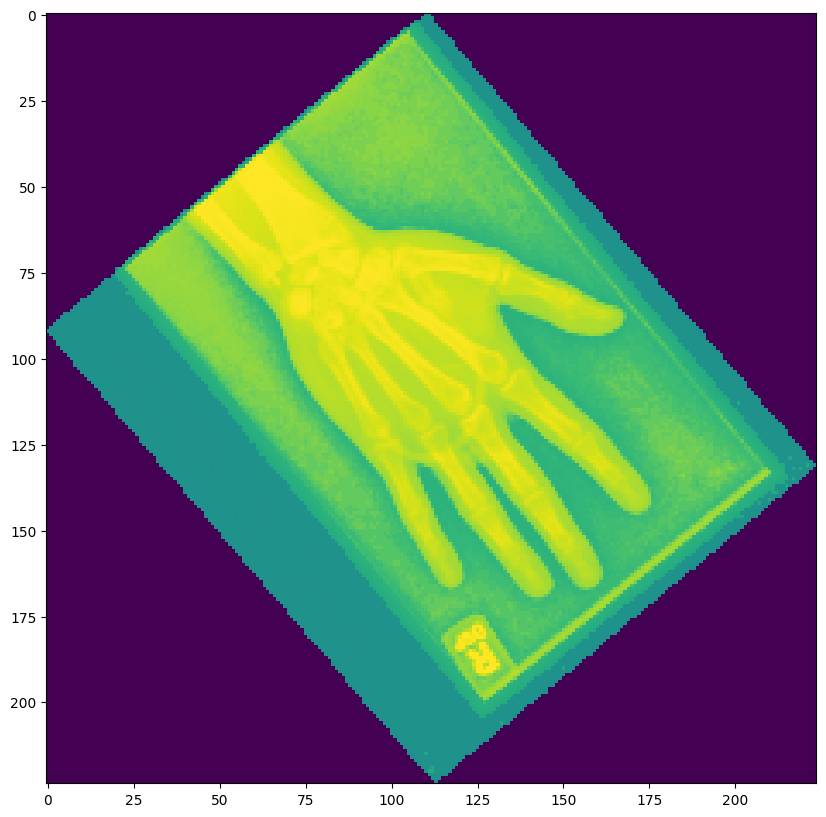

In [6]:
#check dataset
#the first index stands for the index of the images
#the second index implies it is the image not the label
#the third is the index of the channel
img = train_dataset[1][0][0] 
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

img = train_dataset[1][0][1]
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

img = train_dataset[1][0][2]
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

img = train_dataset[1][0][3]
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [7]:
#construct data loader
import torch.utils.data as data
batch_size = 16
VAL_RATIO = 0.2
percent = int(len(train_dataset) * (1 - VAL_RATIO))
train_set, valid_set = data.random_split(train_dataset, [percent, len(train_dataset)-percent])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [8]:
# Find the device available to use using torch library
device = torch.device("cuda")
#device = "cpu"

In [9]:
from torch.autograd import Variable
model = torch.hub.load('pytorch/vision:v0.14.0', 'convnext_base', pretrained=True)
#turn off training for their parameters
for param in model.parameters():
    param.requires_grad = True
    
model.to(device)

Using cache found in /home/u3675487/.cache/torch/hub/pytorch_vision_v0.14.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [10]:
# Assuming `model` is your existing model
weight1 = getattr(model.features, '0')
model1 = getattr(weight1, '0')
weight1 = getattr(weight1, '0').weight.clone()

# Create a new first layer with 4 input channels
new_first_layer = nn.Conv2d(4, 128, kernel_size=(4, 4), stride=(4, 4))

# Copy the weights from the original first layer to the new first layer
new_first_layer.weight[:, :3, :, :].data = weight1

# Replace the original first layer in the model with the new first layer
setattr(model.features, '0', new_first_layer)

# Move the model to the desired device (e.g., GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ConvNeXt(
  (features): Sequential(
    (0): Conv2d(4, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linea

In [11]:
#create new classifier for model using torch.nn as nn library
#classifier_input = model.classifier.linear
classifier_input = getattr(model.classifier, '2')
classifier_input = classifier_input.in_features
num_labels = 2 #PUT IN THE NUMBER OF LABELS IN YOUR DATA
classifier = nn.Sequential(nn.Linear(classifier_input, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 256),
                           nn.ReLU(),
                           nn.Linear(256, num_labels),
                           nn.LogSoftmax(dim=1))
#replace default classifier with new classifier
setattr(model.classifier, '2', classifier)

In [12]:
model.to(device)

ConvNeXt(
  (features): Sequential(
    (0): Conv2d(4, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linea

In [13]:
#set the error function using torch.nn as nn library
criterion = nn.NLLLoss()
#set the optimizer function using torch.optim as optim library
optimizer = optim.Adam(model.parameters(),lr = 0.0005)

1 / 177 Loss =  tensor(0.6582, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6520, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.7542, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6933, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.7761, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6880, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6445, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.7191, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.7259, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6261, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.8108, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.7068, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6697, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

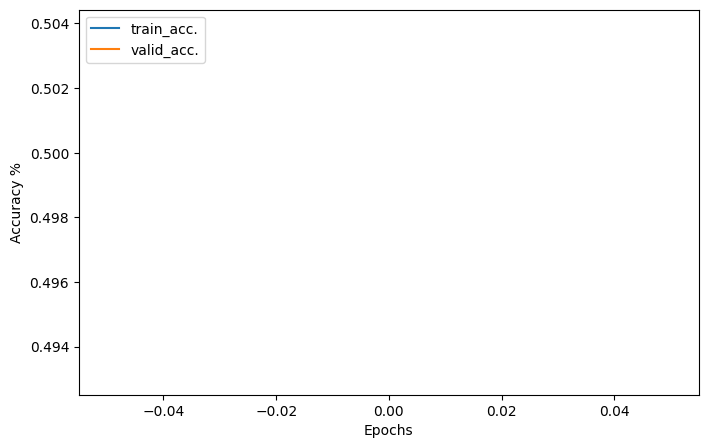

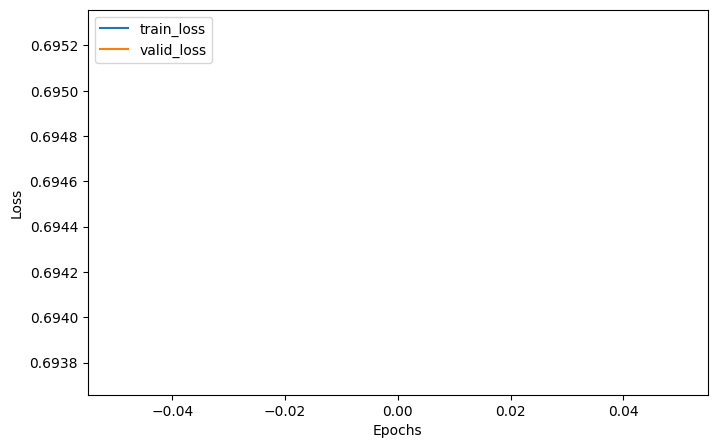

1 / 177 Loss =  tensor(0.6941, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6970, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6892, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6915, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6904, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6920, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6998, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6933, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6927, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6956, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.6939, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6925, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

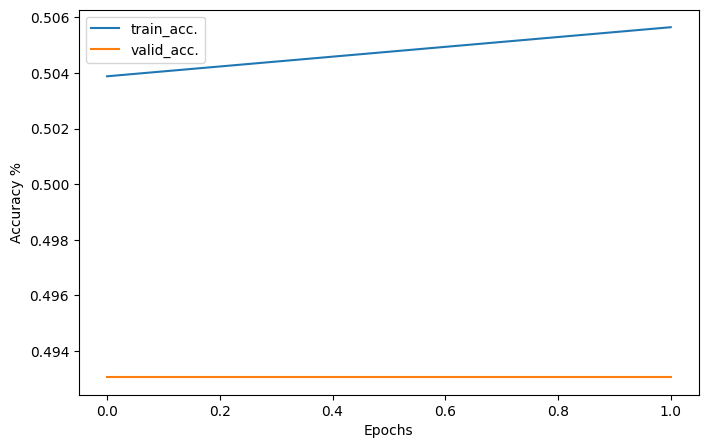

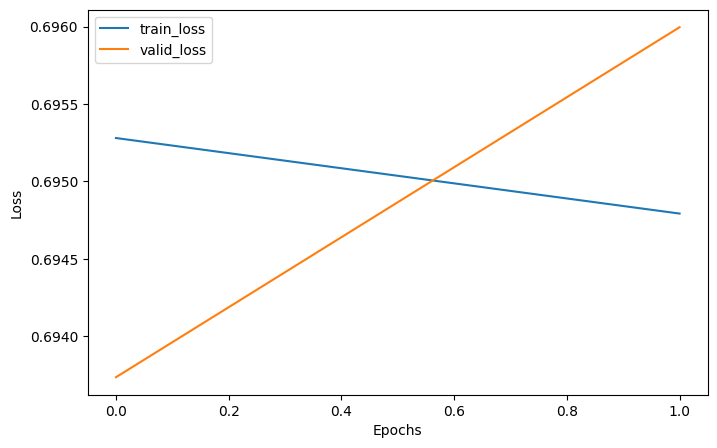

1 / 177 Loss =  tensor(0.7307, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6899, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6818, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6836, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.7130, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6986, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6639, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.7106, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6695, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6988, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6886, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.9146, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.7387, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

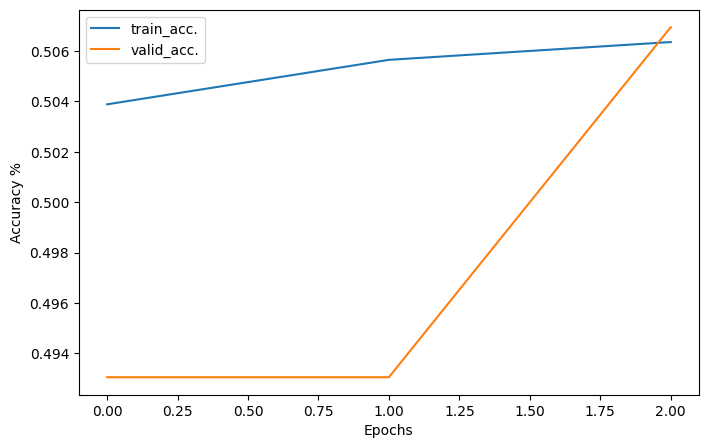

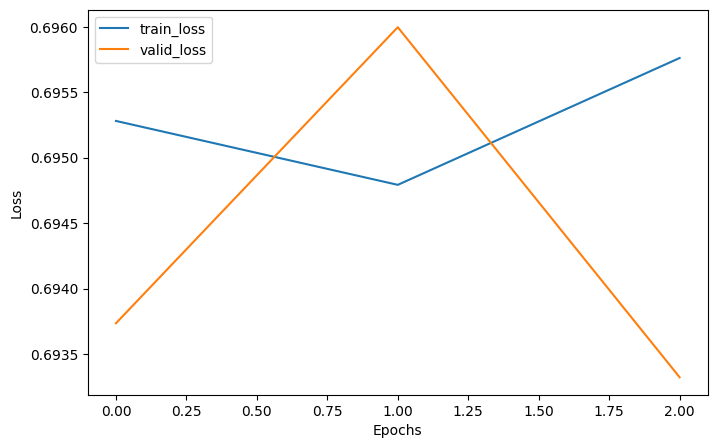

1 / 177 Loss =  tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6893, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6988, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6914, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6908, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6946, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6987, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6917, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6927, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6948, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6889, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.6920, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6910, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

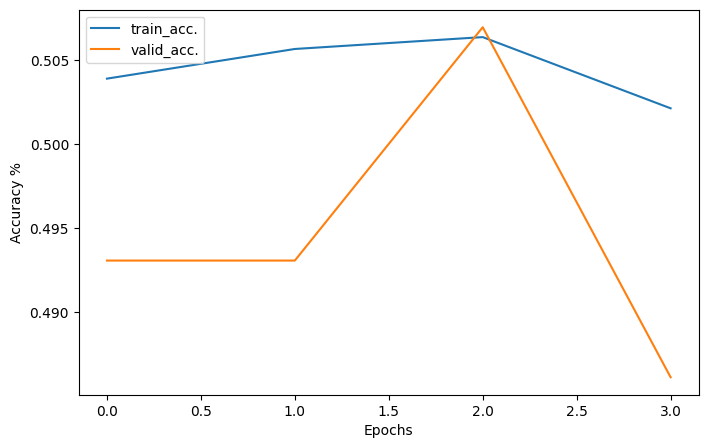

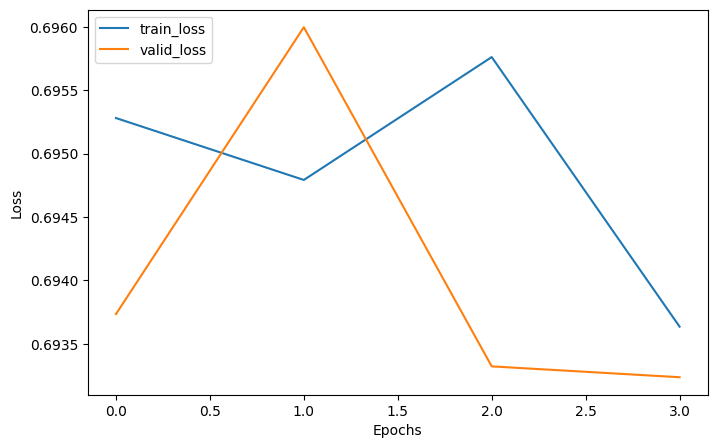

1 / 177 Loss =  tensor(0.6982, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6967, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6925, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6971, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6927, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6949, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6882, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6891, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6966, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6984, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6966, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.6921, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6904, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

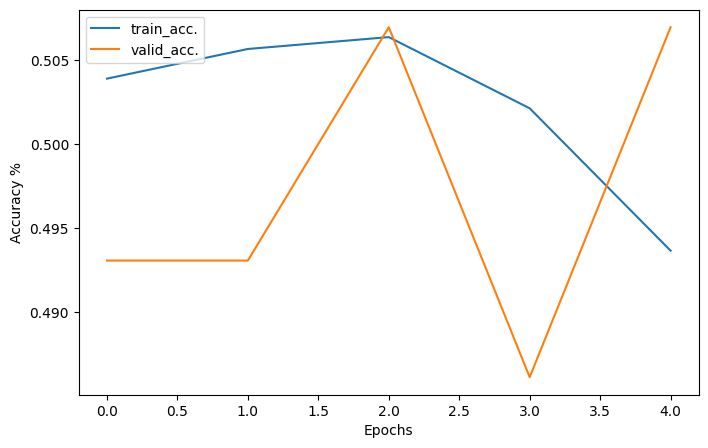

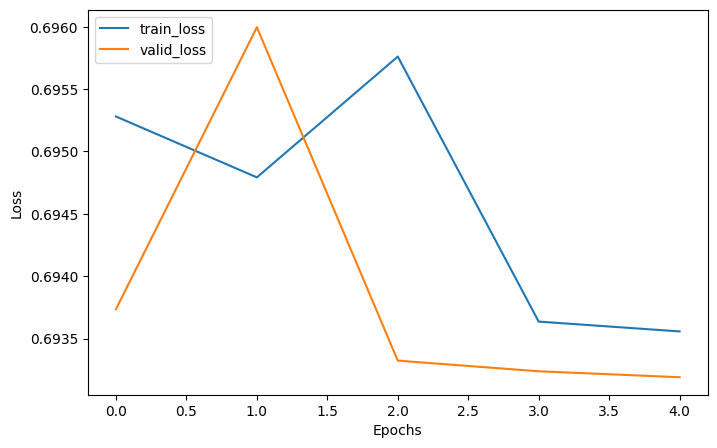

1 / 177 Loss =  tensor(0.6913, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6815, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6895, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6954, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6986, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.7067, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6935, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6926, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6887, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6920, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6908, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.7025, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6975, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

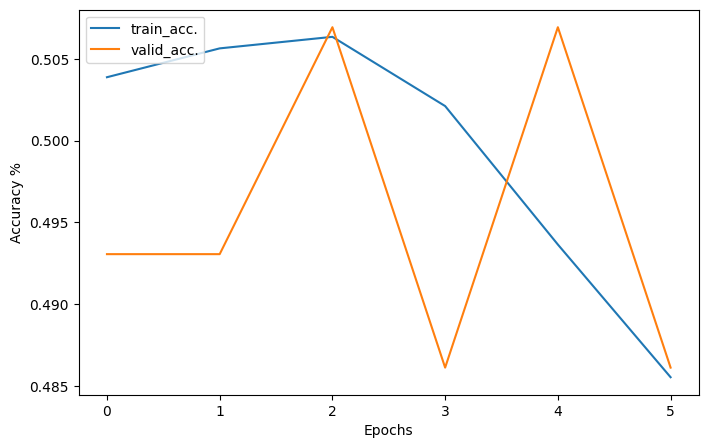

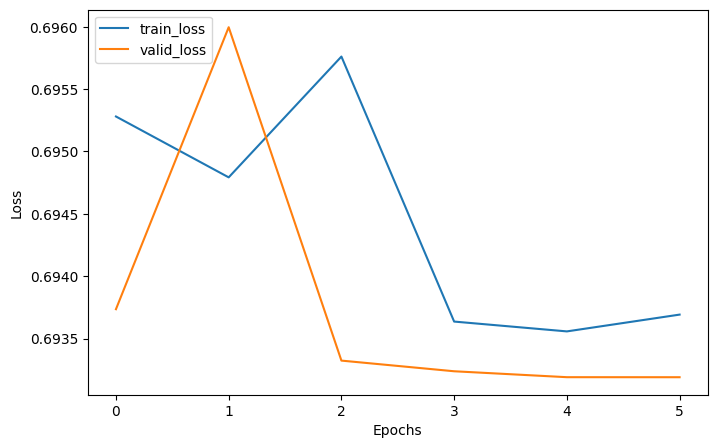

1 / 177 Loss =  tensor(0.6934, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6922, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6907, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6916, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6910, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6949, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6926, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6942, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6905, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6960, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.6950, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6901, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

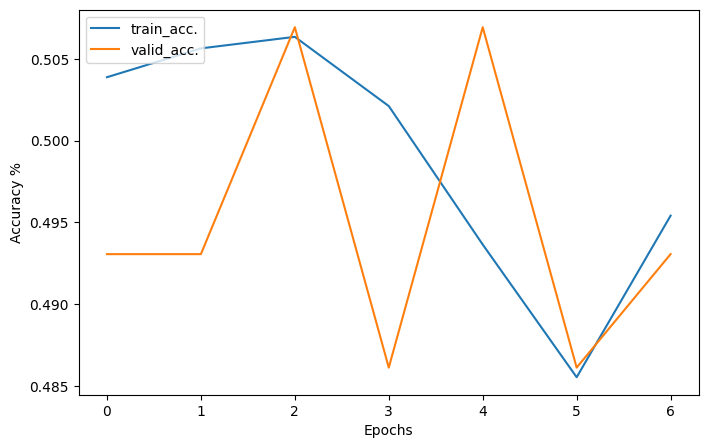

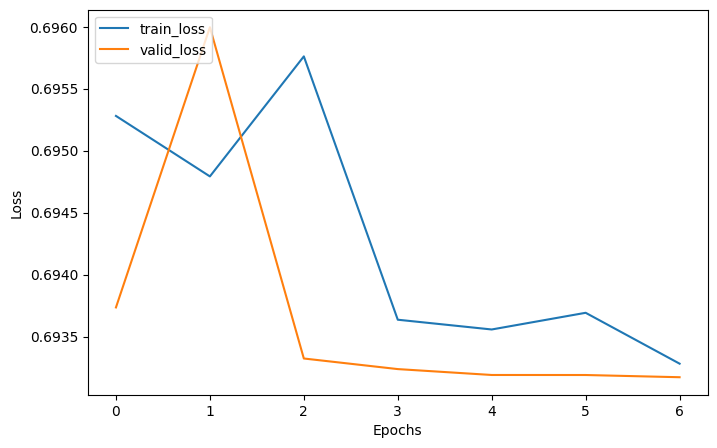

1 / 177 Loss =  tensor(0.6997, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6968, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6994, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6846, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.7001, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6975, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6830, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6876, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6909, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.7011, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.6895, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6937, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

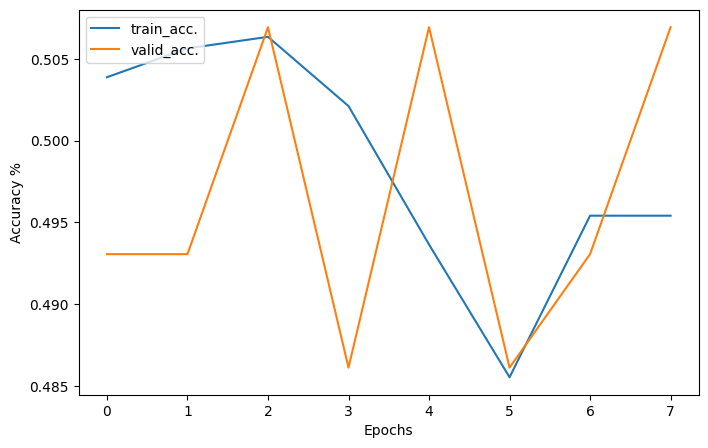

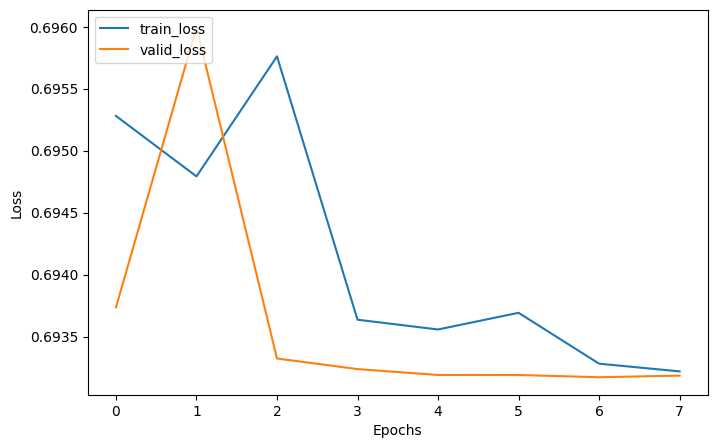

1 / 177 Loss =  tensor(0.6946, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6967, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6896, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6866, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6982, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6927, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.7002, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6967, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6872, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6952, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6833, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.6942, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6956, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

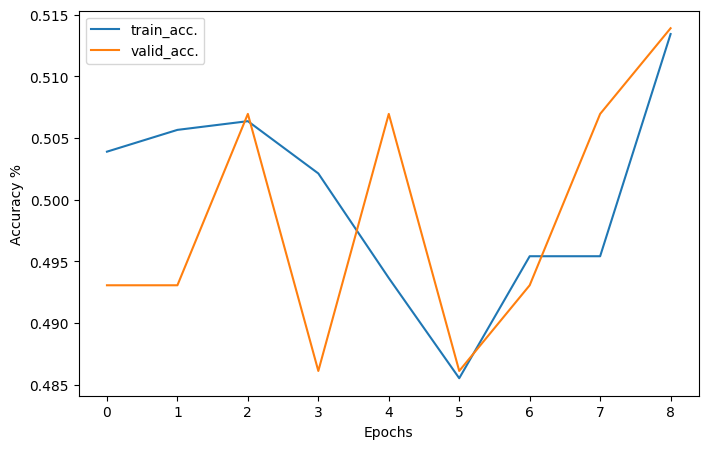

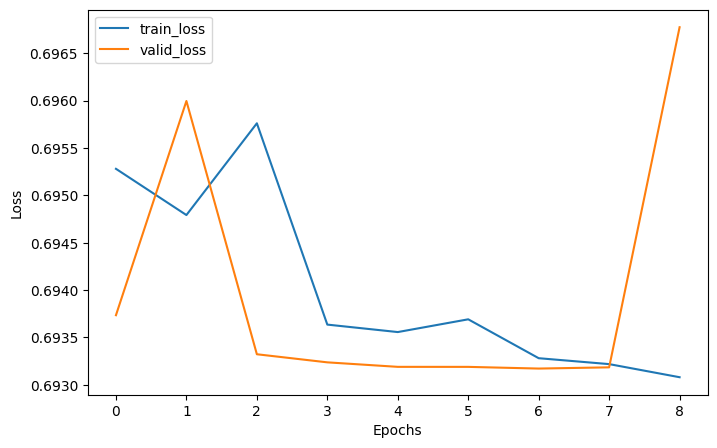

1 / 177 Loss =  tensor(0.6895, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.7133, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.7003, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6639, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6627, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.7165, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.7135, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6807, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6809, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.7126, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6840, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.6922, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.7299, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

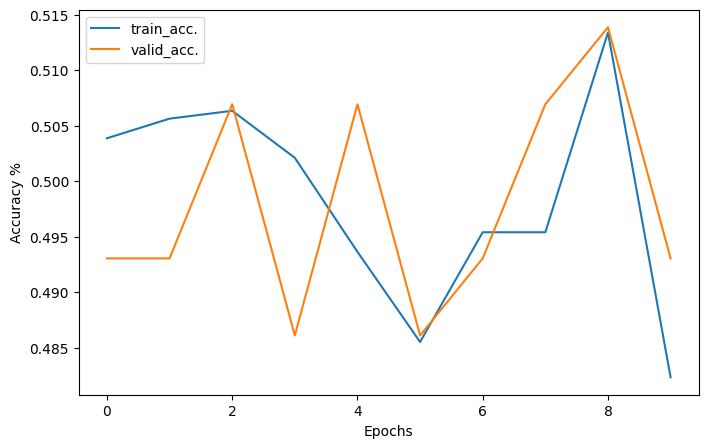

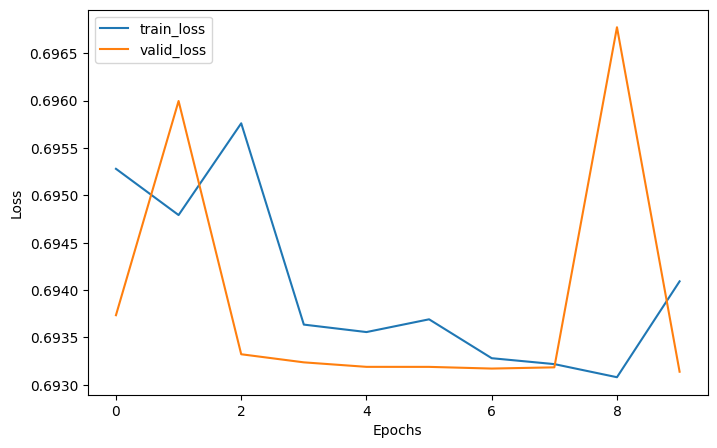

1 / 177 Loss =  tensor(0.6915, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6905, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6975, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6979, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6937, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6939, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6990, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6880, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6923, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6948, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6902, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.6875, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6898, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

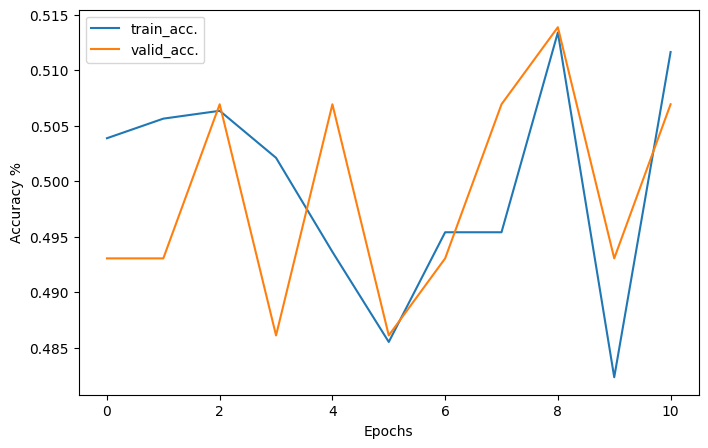

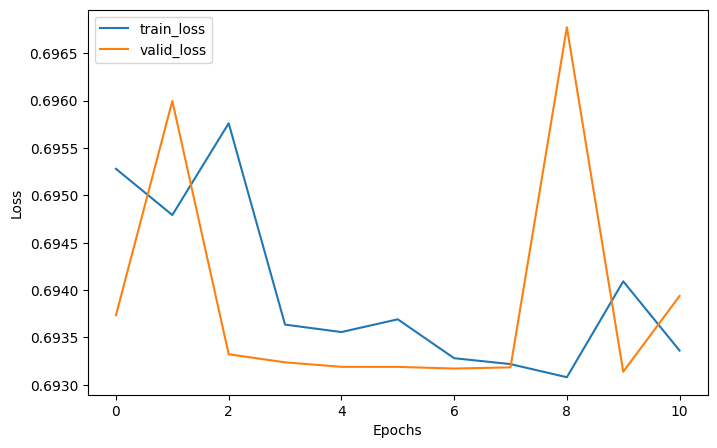

1 / 177 Loss =  tensor(0.6908, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6849, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6861, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.7032, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6977, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6895, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6743, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.7201, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6928, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6837, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.7090, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.7076, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.7106, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

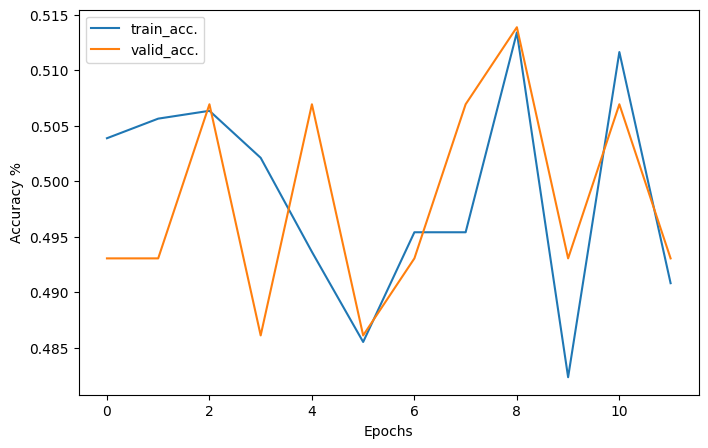

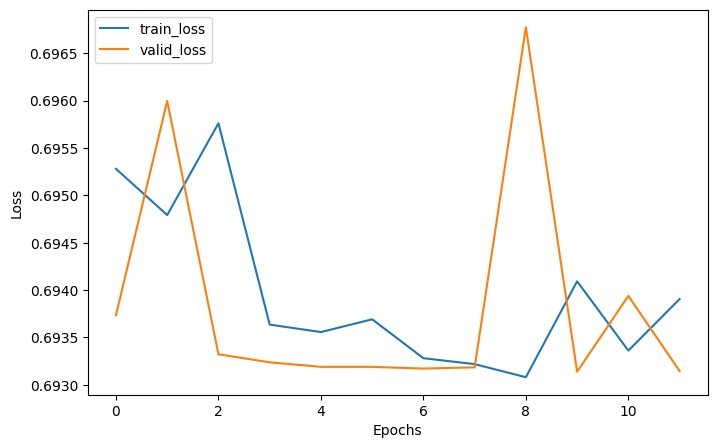

1 / 177 Loss =  tensor(0.6944, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6933, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6929, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6936, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6918, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6924, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6919, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6955, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6940, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6900, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6927, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.6956, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6914, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

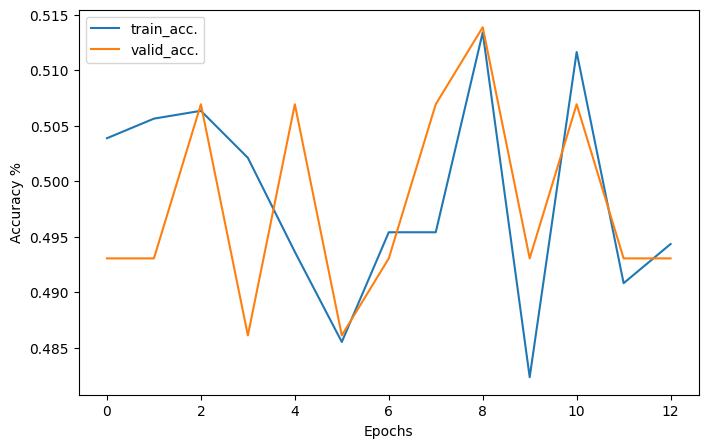

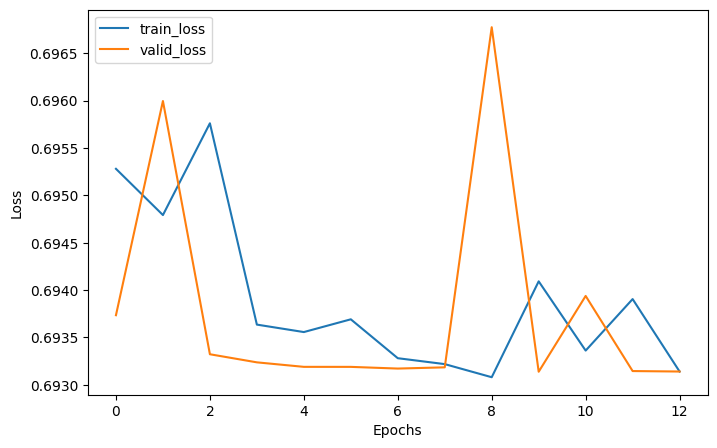

1 / 177 Loss =  tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6937, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6942, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6935, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6925, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6943, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6932, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6927, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6925, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6928, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6926, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.6936, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6929, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

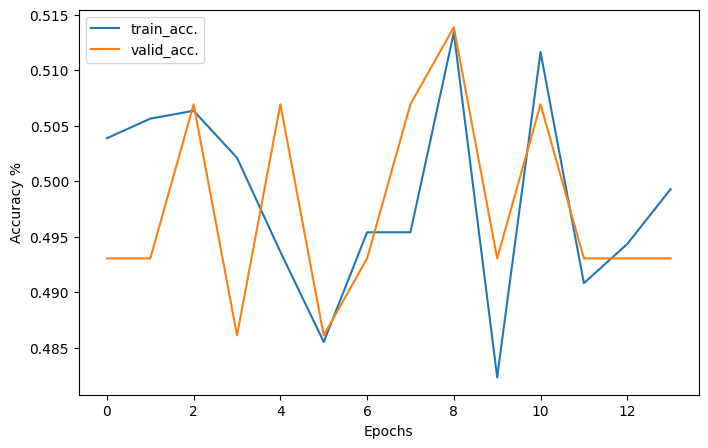

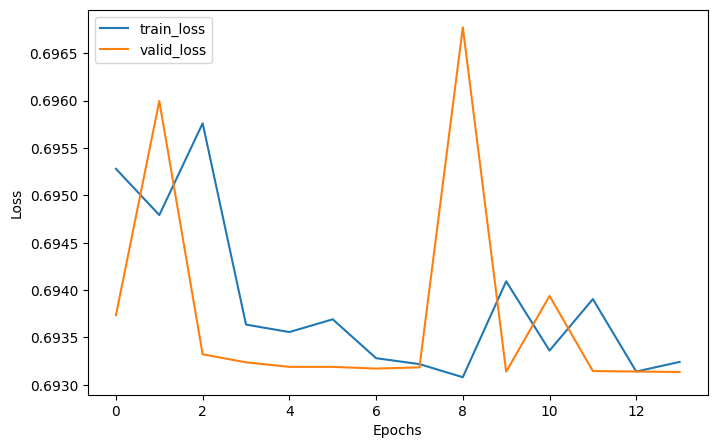

1 / 177 Loss =  tensor(0.6926, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6936, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6937, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6934, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6926, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6941, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6932, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6944, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6942, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6934, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.6929, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6938, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

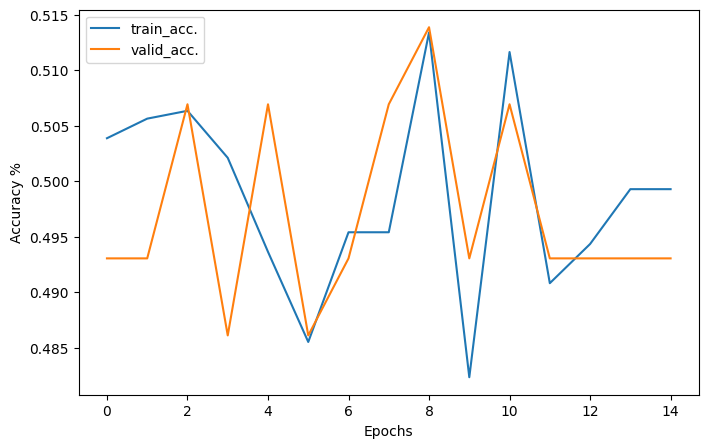

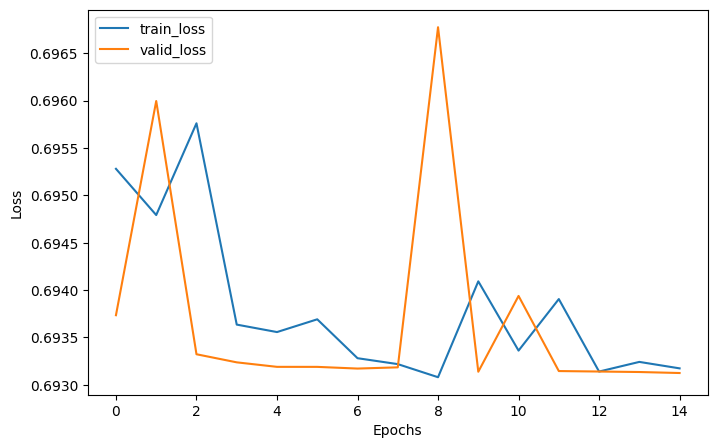

1 / 177 Loss =  tensor(0.6947, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6929, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6938, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6937, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6925, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6938, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6939, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6909, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6916, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6910, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.6957, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6933, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

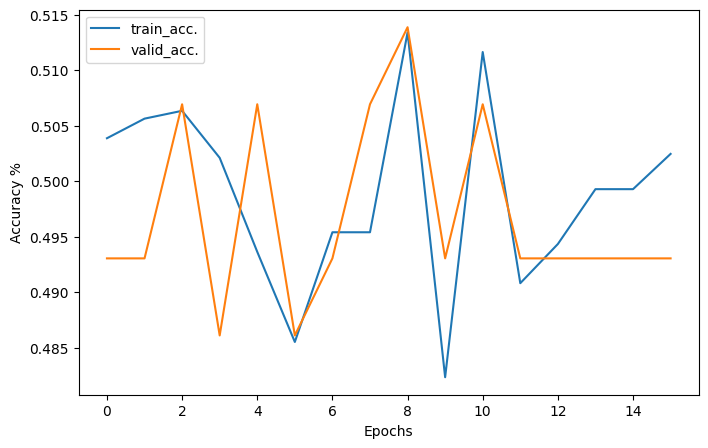

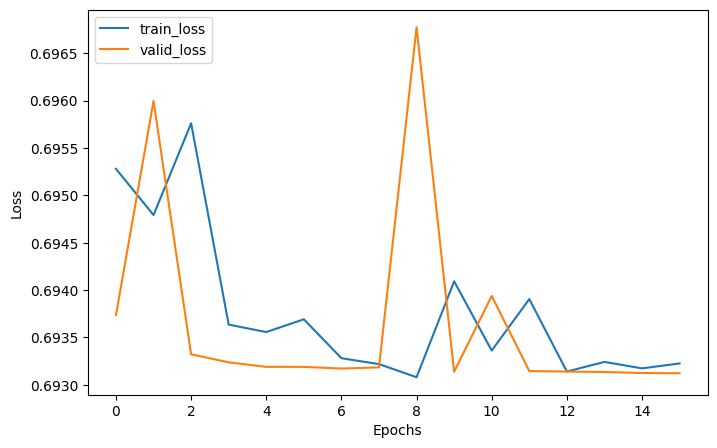

1 / 177 Loss =  tensor(0.6941, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6942, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6952, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6943, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6934, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6946, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6929, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6947, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6941, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6924, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6936, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

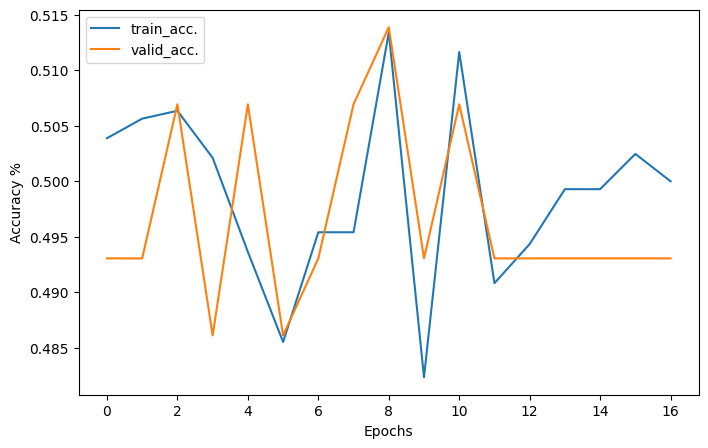

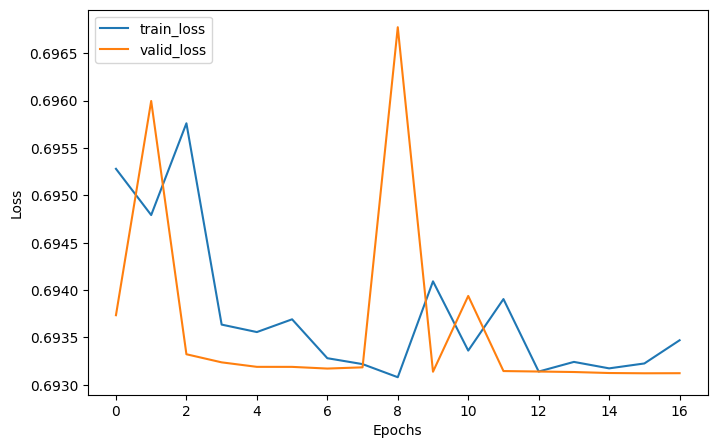

1 / 177 Loss =  tensor(0.6907, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6946, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6910, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6922, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6954, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6939, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6913, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6914, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6933, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.6914, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6914, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

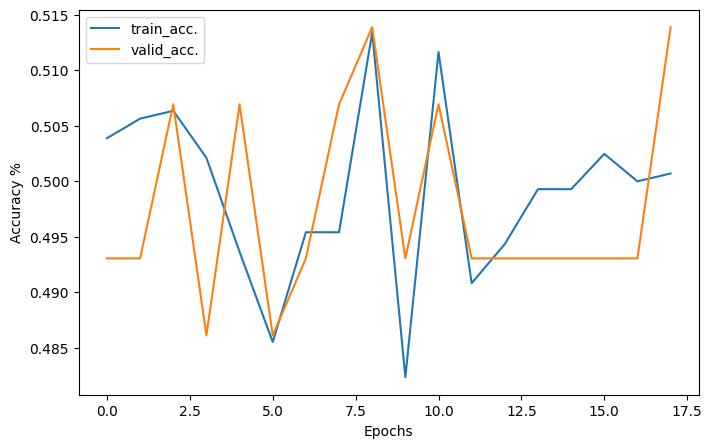

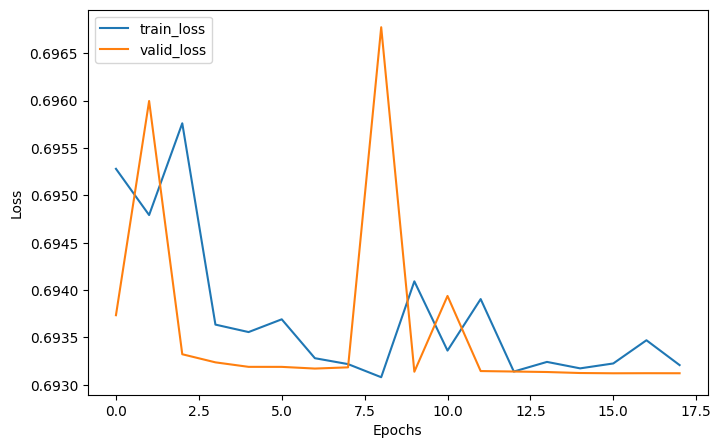

1 / 177 Loss =  tensor(0.6925, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6922, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6935, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6906, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6970, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6911, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6949, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6938, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6941, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6941, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6943, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.6926, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6956, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

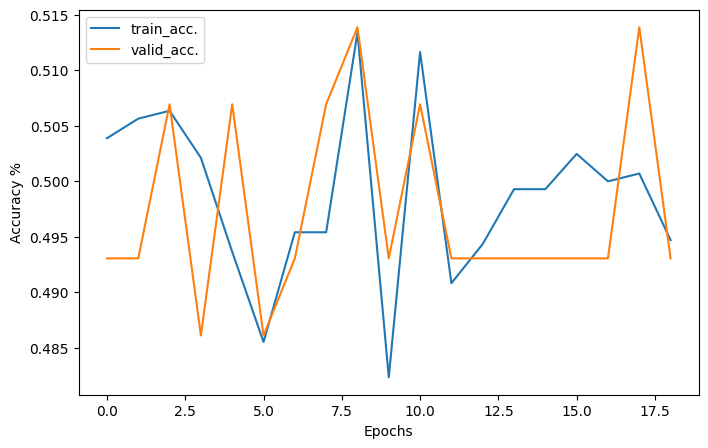

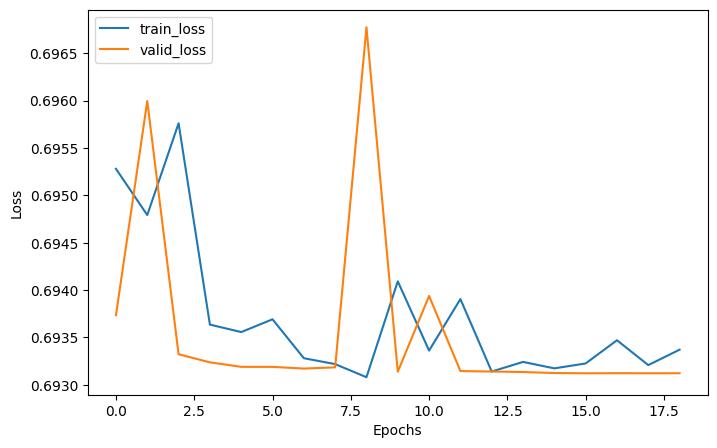

1 / 177 Loss =  tensor(0.6922, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6891, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6964, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6902, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6961, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6912, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6940, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6940, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6929, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6947, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.6948, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6901, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

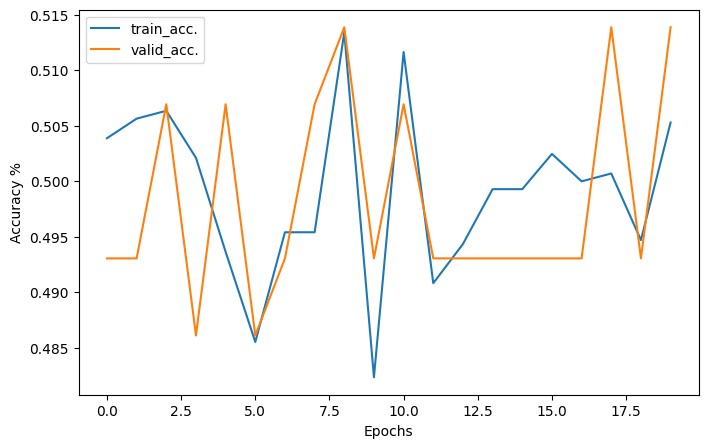

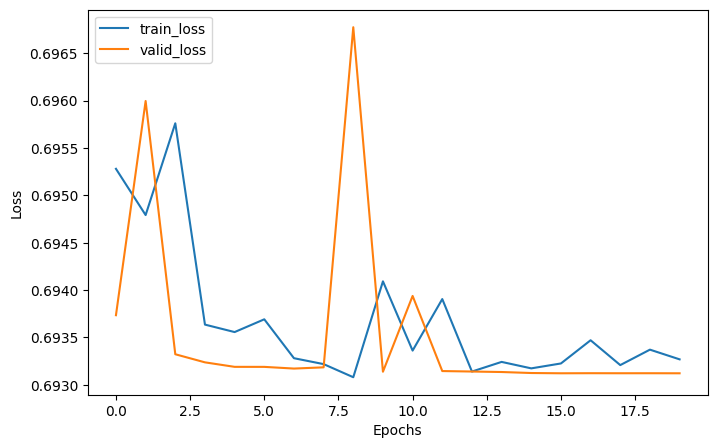

1 / 177 Loss =  tensor(0.6928, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 177 Loss =  tensor(0.6906, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 177 Loss =  tensor(0.6927, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 177 Loss =  tensor(0.6820, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 177 Loss =  tensor(0.6964, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 177 Loss =  tensor(0.6863, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 177 Loss =  tensor(0.6943, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 177 Loss =  tensor(0.6886, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 177 Loss =  tensor(0.6920, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 177 Loss =  tensor(0.6905, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 177 Loss =  tensor(0.6919, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 177 Loss =  tensor(0.6845, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 177 Loss =  tensor(0.6682, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 177

KeyboardInterrupt: 

In [14]:
import matplotlib.pyplot as plt
#training
epochs = 50
best_valid_loss = 10
best_epoch = 0

train_loss_list = []
valid_loss_list = []
acc_train_list = []
acc_valid_list = []

for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    # Training the model
    model.train()
    counter = 0
    for inputs, labels in train_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.type(torch.ByteTensor).to(device)
        # Clear optimizers
        optimizer.zero_grad()
        # Forward pass
        output = model.forward(inputs)
        # Loss
        '''print(output,labels)'''
        loss = criterion(output, labels)
        # Calculate gradients (backpropogation)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        # Add the loss to the training set's rnning loss
        train_loss += loss.item()*inputs.size(0)
        
        # Since our model outputs a LogSoftmax, find the real 
        # percentages by reversing the log function
        output = torch.exp(output)
        # Get the top class of the output
        top_p, top_class = output.topk(1, dim=1)
        # See how many of the classes were correct?
        equals = top_class == labels.view(*top_class.shape)
        # Calculate the mean (get the accuracy for this batch)
        # and add it to the running accuracy for this epoch
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
        # Print the progress of our training
        counter += 1
        print(counter, "/", len(train_loader), "Loss = ", loss)
        
    # Evaluating the model
    model.eval()
    counter = 0
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move to device
            inputs, labels = inputs.to(device), labels.type(torch.ByteTensor).to(device)
            # Forward pass
            output = model.forward(inputs)
            # Calculate Loss
            valloss = criterion(output, labels)
            # Add loss to the validation set's running loss
            val_loss += valloss.item()*inputs.size(0)
            
            # Since our model outputs a LogSoftmax, find the real 
            # percentages by reversing the log function
            output = torch.exp(output)
            # Get the top class of the output
            top_p, top_class = output.topk(1, dim=1)
            # See how many of the classes were correct?
            print("top_class: ", top_class)
            print("labels.view(*top_class.shape): ", labels.view(*top_class.shape))
            equals = top_class == labels.view(*top_class.shape)
            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Print the progress of our evaluation
            counter += 1
            print(counter, "/", len(val_loader), "Accuracy = ", val_accuracy)
    
    # Get the average loss for the entire epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(val_loader.dataset)
    train_acc = train_accuracy / len(train_loader)
    val_acc = val_accuracy / len(val_loader)
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    acc_train_list.append(train_acc)
    acc_valid_list.append(val_acc)
    
    #accuracy_list.append(accuracy/len(val_loader))
    if (valid_loss<best_valid_loss):
      best_valid_loss = valid_loss
      best_epoch = epoch
      #torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/checkpoint.pth')
      print('The saved model is the {} epoch'.format(epoch))
    # Print out the information
    print('Train Accuracy: ', train_accuracy/len(train_loader))
    print('Validation Accuracy: ', val_accuracy/len(val_loader))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    print('Best epoch is {}'.format(best_epoch))
    
    

    plt.figure(figsize=(8, 5))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy %")

    plt.plot(acc_train_list, label = "train_acc.")
    plt.plot(acc_valid_list, label = "valid_acc.")
    plt.legend(loc=2)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.plot(train_loss_list, label = "train_loss")
    plt.plot(valid_loss_list, label = "valid_loss")
    plt.legend(loc=2)
    plt.show()

In [ ]:
#testing
#evaluation mode
model.eval()
result = []  #storing the result of prediction (probability of being positive/abnormal)
count = 0
with torch.no_grad(): #don't calculate the gradient
    for inputs in test_loader:
        # Move to device
        inputs = inputs.to(device)
        # Forward pass
        output = model.forward(inputs)
        count += 1
        print(count,'/',len(test_loader))
        #store the result
        result.append(np.exp(float((output[0][1]).cpu())))

#output the prediction
#generate list of image id
test_folder = 'data_path/test'
image_id = []
for i in range (len(test_paths)):
    image_id.append(test_paths[i][-len(test_paths[i])+len(test_folder)+1:-11])
#build data frame for pandas library
df = pd.DataFrame({'id':image_id,
                  'label':result})
#construct csv file for submission
#df.to_csv('/content/drive/My Drive/Colab Notebooks/submission.csv',index=False)